# Technical Analysis for Stock Price Prediction Using LSTM #
Team Members: Anjan Shrestha, Balaji Mandava, Byanagari Rohith, Naresh Balla, Bhargav Ram Pushadapu

Group Number: 8

### Import and Packages ###

In [1]:
# For dealing with dataframe
import pandas as pd

# For dealing with np array
import numpy as np

# For calling yahoo finance to get stock price 
import yfinance as yf
import datetime as dt
from datetime import timedelta
import math 
import os

# For exporting trained model
import pickle

# For plotting
import matplotlib.pyplot as plt

# For model
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

### Model Properties ###

In [2]:
# Dataset Properties
DATE = 'Date'
CLOSE = 'Close'
VOLUME = 'Volume'

# Stock Properties 
STOCK_TICKER = os.environ['STOCK_TICKER'] if 'STOCK_TICKER' in os.environ else 'AAPL' # Retrive stock ticker from environment variable

# Target
NUMBER_OF_DAYS_TO_PREDICT = 30 # Target Stock Trend

# Custom Hyperparameters
NUMBER_OF_INTERVAL_FOR_PRICE_PREDICTION = 20

# LSTM Hyperparameters
NUMBER_OF_EPOCH = 25
BATCH_SIZE = 30

##  1. Extract Raw data and Dataset Creation ##
Calling Yahoo Finance API to extract data for last 'n' years from current date and convert it to dataframe

In [3]:
df = pd.DataFrame()

# Loop call to yfinance API since data can be fetched for 7 days at once with maximum of 30 days
total_days = 29
for n in range(math.ceil(total_days/7)):
    days = total_days - n*7 
        
    start_date = dt.datetime.today() - dt.timedelta(days=days)
    print(start_date)

    end_date = dt.datetime.today() - dt.timedelta(days= (days - 7 if days > 7  else 0))
    df = pd.concat([df, yf.download(STOCK_TICKER, start=start_date, end=end_date, interval='1m')])

2023-03-13 15:29:37.624807
[*********************100%***********************]  1 of 1 completed
2023-03-20 15:29:38.089516
[*********************100%***********************]  1 of 1 completed
2023-03-27 15:29:38.406474
[*********************100%***********************]  1 of 1 completed
2023-04-03 15:29:38.750178
[*********************100%***********************]  1 of 1 completed
2023-04-10 15:29:39.062651
[*********************100%***********************]  1 of 1 completed


In [17]:
df.shape


(7786, 6)

In [18]:
df.head(5)



,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-03-13 15:30:00-04:00,151.050003,151.300003,151.009995,151.145004,151.145004,0
2023-03-13 15:31:00-04:00,151.139999,151.179993,151.020004,151.160904,151.160904,129968
2023-03-13 15:32:00-04:00,151.160004,151.255005,151.000000,151.009995,151.009995,191684
2023-03-13 15:33:00-04:00,151.000000,151.350006,150.980103,151.279999,151.279999,192353
2023-03-13 15:34:00-04:00,151.279999,151.360001,151.210007,151.250000,151.250000,124118


## 2. Exploratory Data Analysis

<AxesSubplot:title={'center':'Stock Price Movement for last 30 days'}, xlabel='Datetime', ylabel='Stock Price'>

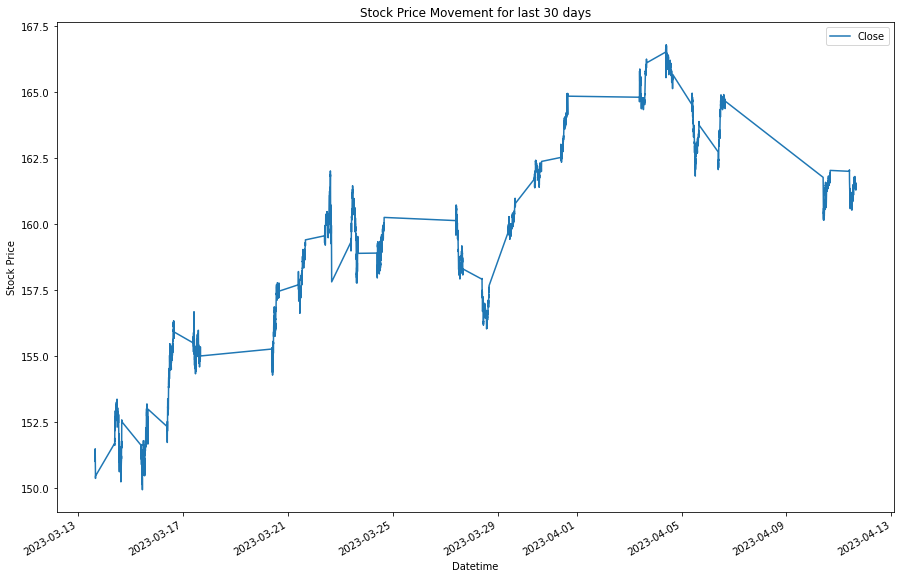

In [6]:
# Plotting the graph visualizing price change with date
df.plot(y=[CLOSE],figsize=(15,10), ylabel='Stock Price', title='Stock Price Movement for last 30 days')

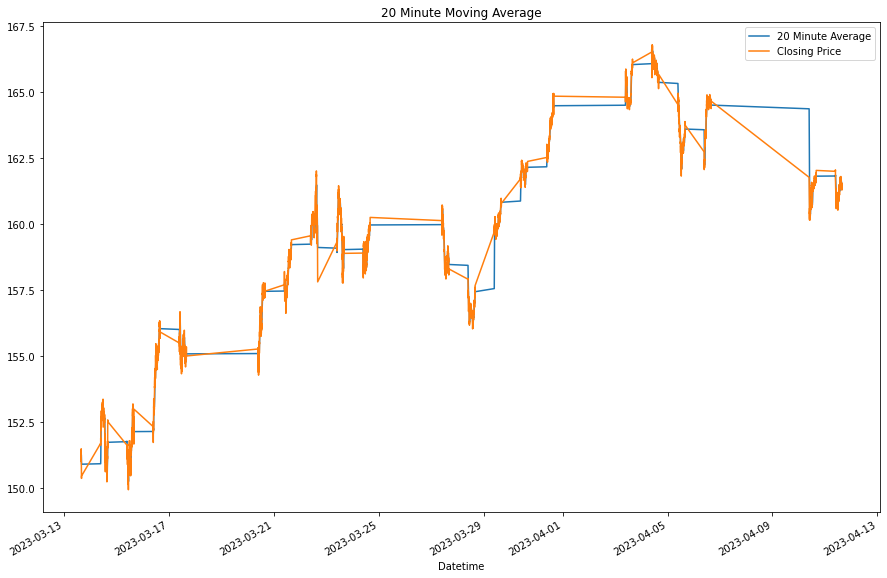

In [7]:
# Plotting moving average
plt.figure(figsize=(15,10))
df[CLOSE].rolling(window=20).mean().plot(label='20 Minute Average')
df[CLOSE].plot(label='Closing Price', title='20 Minute Moving Average')
plt.legend()

## 3. Feature Selection ##

In [8]:
# Function to extract Stock Closing Price as a Feature from Dataframe
model_df = df.reset_index()[CLOSE]

scaler = MinMaxScaler(feature_range=(0,1))
model_df = scaler.fit_transform(np.array(model_df).reshape(-1,1))

## 4. Split Data into Train and Test ##

In [9]:
# Splitting first 70% data into training set and last 30% into testing set
train_index = 0.7 * model_df.shape[0]
train_data = model_df[:int(train_index)]
test_data = model_df[int(train_index):]

In [10]:
# Function to create dataset into feature and target
def create_dataset_lstm(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# Creating training and testing dataset
X_train, y_train = create_dataset_lstm(train_data, NUMBER_OF_INTERVAL_FOR_PRICE_PREDICTION)
X_test, y_test = create_dataset_lstm(test_data, NUMBER_OF_INTERVAL_FOR_PRICE_PREDICTION)
                
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## 5. Training the model

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(NUMBER_OF_INTERVAL_FOR_PRICE_PREDICTION,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=NUMBER_OF_EPOCH, batch_size=BATCH_SIZE, verbose=0)


## 6. Evaluating the model

In [13]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(np.array(y_test).reshape(-1,1))
current_rmse = math.sqrt(mean_squared_error(y_pred, y_test))

In [14]:
current_rmse


0.22673504319473453

## 7. Generating trained model to output file


In [15]:
# Output to pickle file
output = {
    'trained_model': model,
    'latest_interval_data': np.array(model_df[len(model_df) - NUMBER_OF_INTERVAL_FOR_PRICE_PREDICTION:]),
    'scaler': scaler,
    'rmse': current_rmse
}

with open('./output/output-{}.pickle'.format(STOCK_TICKER), 'wb') as f:
    pickle.dump(output, f)
    
    
    

2023-04-11 15:31:37.231085: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://941c4285-8ccc-4ad8-a29a-15eb812bf77f/assets


INFO:tensorflow:Assets written to: ram://941c4285-8ccc-4ad8-a29a-15eb812bf77f/assets
